# Time Series Final Project
## News Articles EDA
In the following part, we will focus on obtaining sentiment scores for news articles centered around technology topics. More specifically, we would like to focus on articles mentioning companies that are captured under the MiraeAsset TIGER US Tech Top10 INDXX (https://www.bloomberg.com/quote/381170:KS#xj4y7vzkg)

Companies under the index are:
* Microsoft Corp. MSFT:US.
* Apple Inc. AAPL:US. 1.3579M.
* Alphabet Inc. GOOGL:US. 1.9099M.
* Amazon.com Inc. AMZN:US.
* NVIDIA Corp. NVDA:US.
* Meta Platforms Inc. META:US.
* Tesla Inc. TSLA:US. 402.9600K.
* Broadcom Inc. AVGO:US. 60.7200K.

In [3]:
%pip install transformers xformers pandarallel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 38.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 24.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.6/756.6 kB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.4 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 24.3 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd

from transformers import pipeline
sentiment_analysis = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english")

In [5]:
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

Available CPUs: 8


In [6]:
df_news = pd.read_parquet('https://storage.googleapis.com/msca-bdp-data-open/news_final_project/news_final_project.parquet', engine='pyarrow')

In [7]:
df_news.head()

,url,date,language,title,text
0,http://en.people.cn/n3/2021/0318/c90000-983012...,2021-03-18,en,Artificial intelligence improves parking effic...,\n\nArtificial intelligence improves parking e...
1,http://newsparliament.com/2020/02/27/children-...,2020-02-27,en,Children With Autism Saw Their Learning and So...,\nChildren With Autism Saw Their Learning and ...
2,http://www.dataweek.co.za/12835r,2021-03-26,en,"Forget ML, AI and Industry 4.0 – obsolescence ...","\n\nForget ML, AI and Industry 4.0 – obsolesce..."
3,http://www.homeoffice.consumerelectronicsnet.c...,2021-03-10,en,Strategy Analytics: 71% of Smartphones Sold Gl...,\n\nStrategy Analytics: 71% of Smartphones Sol...
4,http://www.itbusinessnet.com/2020/10/olympus-t...,2020-10-20,en,Olympus to Support Endoscopic AI Diagnosis Edu...,\n\nOlympus to Support Endoscopic AI Diagnosis...


Let's start doing some EDA and cleaning our text column to feed into a sentiment analysis pipeline

In [8]:
# Assuming you have a pandas DataFrame named 'df' with a 'date' column
df_news['date'] = pd.to_datetime(df_news['date'])  # Convert 'date' column to pandas Timestamp if not already

min_date = df_news['date'].min()
max_date = df_news['date'].max()

print("Minimum date:", min_date)
print("Maximum date:", max_date)

Minimum date: 2020-01-01 00:00:00
Maximum date: 2023-04-28 00:00:00


In [12]:
# !pip install nltk

In [13]:
import nltk
from nltk.corpus import stopwords
import string

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Preprocessing the text

In [14]:
from pandarallel import pandarallel

pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False, progress_bar=True)

INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [15]:
def preprocess_text(text):
    # Remove punctuation and numbers
    text = text.translate(str.maketrans('', '', string.punctuation + string.digits))
    
    # Convert text to lowercase
    text = text.lower()
    
    # Tokenize the text
    tokens = text.split()
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Join the tokens back into a single string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

df_processed = df_news.copy()
df_processed['text_processed'] = df_processed['text'].parallel_apply(preprocess_text)

In [16]:
df_processed.head()

,url,date,language,title,text,text_processed
0,http://en.people.cn/n3/2021/0318/c90000-983012...,2021-03-18,en,Artificial intelligence improves parking effic...,\n\nArtificial intelligence improves parking e...,artificial intelligence improves parking effic...
1,http://newsparliament.com/2020/02/27/children-...,2020-02-27,en,Children With Autism Saw Their Learning and So...,\nChildren With Autism Saw Their Learning and ...,children autism saw learning social skills boo...
2,http://www.dataweek.co.za/12835r,2021-03-26,en,"Forget ML, AI and Industry 4.0 – obsolescence ...","\n\nForget ML, AI and Industry 4.0 – obsolesce...",forget ml ai industry – obsolescence focus feb...
3,http://www.homeoffice.consumerelectronicsnet.c...,2021-03-10,en,Strategy Analytics: 71% of Smartphones Sold Gl...,\n\nStrategy Analytics: 71% of Smartphones Sol...,strategy analytics smartphones sold globally a...
4,http://www.itbusinessnet.com/2020/10/olympus-t...,2020-10-20,en,Olympus to Support Endoscopic AI Diagnosis Edu...,\n\nOlympus to Support Endoscopic AI Diagnosis...,olympus support endoscopic ai diagnosis educat...


### Filter articles that only refer to the tech companies we are interested in

In [17]:
tech_companies = ['microsoft', 'google', 'alphabet', 'meta', 'facebook', 'apple', 'amazon', 'nvidia', 'tesla', 'broadcom']

# Create a boolean mask to filter the rows based on the tech companies mentioned
mask = df_processed['text_processed'].str.contains('|'.join(tech_companies), case=False)

# Apply the mask to filter the DataFrame
filtered_df = df_processed[mask]

In [11]:
#pip install pandarallel

In [22]:
from nltk import word_tokenize
nltk.download('punkt')

type(word_tokenize("test deneme deneme 123"))

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


list

### Getting the count of articles for each date

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


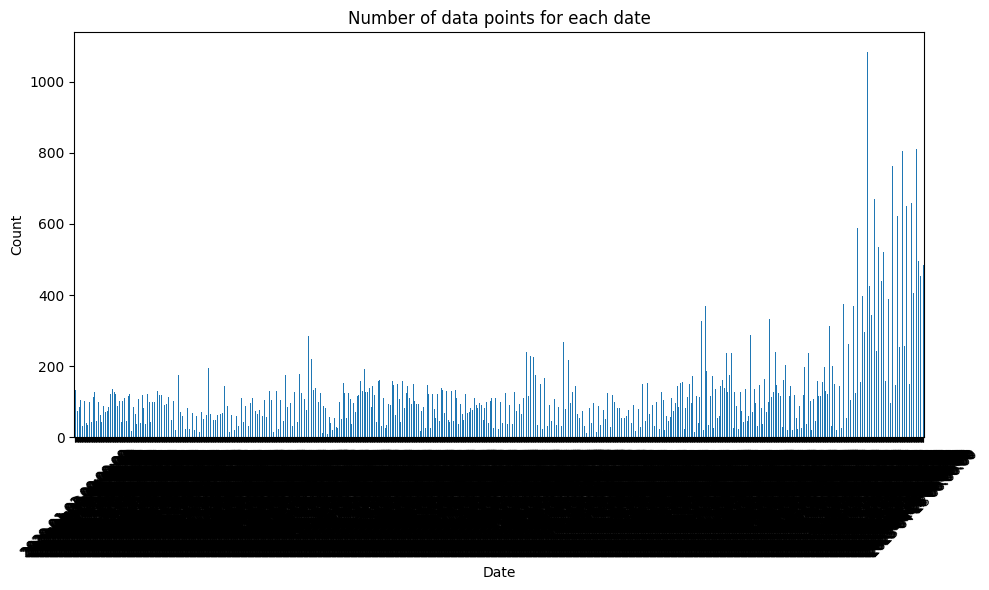

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume that df is your DataFrame and 'date' is your date column
# df = pd.DataFrame(your_data)

# Convert the 'date' column to datetime if it's not already
filtered_df['date'] = pd.to_datetime(filtered_df['date'])

# Count the number of data points for each date
date_counts = filtered_df['date'].value_counts().sort_index()

# Plot the data
plt.figure(figsize=(10, 6))
date_counts.plot(kind='bar')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Number of data points for each date')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [67]:
### Chunk the text considering the token limit
from datetime import datetime

text_cache = []
print("Process started at ", datetime.now())
for idx, row in filtered_df.iterrows():    
    if idx % 5000 == 0:
        print(f"The data is processed until {idx} at", datetime.now())

    max_word_length = 500
    max_token_length = 450

    long_text = row["text_processed"]
    long_text = " ".join(word_tokenize(long_text)[:max_word_length])
    
    # Truncate the input text to the maximum length using the model's tokenizer
    tokens = sentiment_analysis.tokenizer.tokenize(long_text)
    tokens = tokens[:max_token_length]
    truncated_text = sentiment_analysis.tokenizer.convert_tokens_to_string(tokens)
    
    text_cache.append(truncated_text)

Process started at  2023-05-19 21:36:43.839191
The data is processed until 0 at 2023-05-19 21:36:44.775901
The data is processed until 5000 at 2023-05-19 21:37:21.815603
The data is processed until 10000 at 2023-05-19 21:37:58.255186
The data is processed until 20000 at 2023-05-19 21:39:11.819249
The data is processed until 25000 at 2023-05-19 21:39:48.332970
The data is processed until 30000 at 2023-05-19 21:40:25.066603
The data is processed until 35000 at 2023-05-19 21:41:01.978087
The data is processed until 40000 at 2023-05-19 21:41:38.699237
The data is processed until 45000 at 2023-05-19 21:42:16.172056
The data is processed until 50000 at 2023-05-19 21:42:53.023368
The data is processed until 55000 at 2023-05-19 21:43:30.189365
The data is processed until 60000 at 2023-05-19 21:44:07.634330
The data is processed until 65000 at 2023-05-19 21:44:46.372275
The data is processed until 85000 at 2023-05-19 21:47:14.275749
The data is processed until 90000 at 2023-05-19 21:47:50.02088

In [68]:
filtered_df["truncated_text"] = text_cache

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Sample news articles to a threshold for each date

In [84]:
# Convert the 'date' column to datetime if it's not already
filtered_df['date'] = pd.to_datetime(filtered_df['date'])

# Define the number of rows to select from each date
X = 10 

# Group the data by date and select the first X rows from each group
filtered_df_2 = filtered_df.groupby('date').apply(lambda x: x.head(X)).reset_index(drop=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [85]:
len(filtered_df_2)

12130

In [86]:
filtered_df_2 = filtered_df_2[filtered_df_2.date >= '2022-05-01']

In [87]:
len(filtered_df_2)

3630

### Get sentiment scores

In [88]:
text_cache = list(filtered_df_2["truncated_text"])

In [ ]:
%%time

sentiment_responses = []
max_elements_to_send = 20
num_of_batches = len(text_cache)//max_elements_to_send

print("Starting at ", datetime.now())

for i in range(1, num_of_batches):
    if i % 10 == 0:
        print(f"The data is processed until {i} out of {num_of_batches} batches at", datetime.now())
        
    try:
        parsed_texts = text_cache[max_elements_to_send*(i-1):max_elements_to_send*i]
        sentiment_responses.append(sentiment_analysis(parsed_texts))
    except:
        sentiment_responses.append(sentiment_analysis(text_cache[max_elements_to_send*(i-1):]))

Starting at  2023-05-19 22:18:35.645515
The data is processed until 10 out of 181 batches at 2023-05-19 22:22:42.405086
The data is processed until 20 out of 181 batches at 2023-05-19 22:27:18.028361
The data is processed until 30 out of 181 batches at 2023-05-19 22:31:51.117102
The data is processed until 40 out of 181 batches at 2023-05-19 22:36:26.176054
The data is processed until 50 out of 181 batches at 2023-05-19 22:40:58.489323
The data is processed until 60 out of 181 batches at 2023-05-19 22:45:29.985691
The data is processed until 70 out of 181 batches at 2023-05-19 22:49:58.314012
The data is processed until 80 out of 181 batches at 2023-05-19 22:54:28.761399


In [105]:
filtered_df_2.reset_index(drop=True, inplace=True)

In [106]:
filtered_df_2 = filtered_df_2.iloc[:max_elements_to_send*i]

In [116]:
backup = copy.deepcopy(sentiment_responses)

In [120]:
final_sentiment_scores = [item for sublist in sentiment_responses for item in sublist]

In [122]:
df = pd.DataFrame(final_sentiment_scores)

In [127]:
final_df = pd.concat([filtered_df_2, df], axis=1)

In [129]:
final_df.label.value_counts()

POSITIVE    3197
NEGATIVE     403
Name: label, dtype: int64

In [131]:
final_df.to_csv("news_sentiments.csv", index=False)

In [133]:
import datetime
import pytz

datetime.datetime.now(pytz.timezone('US/Central')).strftime("%a, %d %B %Y %H:%M:%S")

'Fri, 19 May 2023 19:19:32'